# CO2 Group - Version 2
OOI Data Labs Workshop - July 2019

Revised 1/31/20

**Working Title**: CO2 exchange between air and sea (Application phase)

**Short Description**: 
* Exploration: Explore factors that control the concentration of CO2 in the ocean and exchanges of CO2 between the ocean and atmosphere
* Application: Evaluate whether a mystery site is a source or a sink of CO2, discuss the environmental factors that determine this, and predict the location of the mystery site by comparing to known regions

In [3]:
# Notebook Setup
import requests
import os
import re
import xarray as xr
! pip install netcdf4==1.5.0
import matplotlib.pyplot as plt
import datetime 
import pandas as pd

# Setup default plot styles
import seaborn as sns
sns.set()

# Supress open_mfdataset warnings
import warnings
warnings.filterwarnings('ignore')

## Step 1 - Request Data from OOINet (only run once)

* **Time range:** 2016-01-01 00:00:00 to 2020-01-01 00:00:00 (if available)
* **Variables:** PCO2 Air/Water, Seawater Temperature, Salinity, Wind Speed, Chlorophyll
* **Instruments** recovered_host pco2a_a_dcl_instrument_air_recovered (includes water)
  * CE02SHSM-SBD12-04-PCO2AA000 Oregon Shelf Surface Mooring
  * CP01CNSM-SBD12-04-PCO2AA000 Pioneer Central Surface Mooring
  * CP03ISSM-SBD12-04-PCO2AA000 Pioneer Inshore Surface Mooring

In [0]:
def request_data(reference_designator,method,stream,start_date=None,end_date=None):
  site = reference_designator[:8]
  node = reference_designator[9:14]
  instrument = reference_designator[15:]
  
  # Create the request URL
  api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
  data_request_url ='/'.join((api_base_url,site,node,instrument,method,stream))

  # All of the following are optional, but you should specify a date range
  params = {
    'format':'application/netcdf',
    'include_provenance':'true',
    'include_annotations':'true'
  }
  if (start_date):
    params['beginDT'] = start_date
  if (end_date):
    params['endDT'] = end_date

  # Make the data request
  r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
  data = r.json()
  
  # Return just the THREDDS URL
  return data['allURLs'][0] 

In [0]:
API_USERNAME = ''
API_TOKEN = ''

In [0]:
# Telemetered
# request_data('CE02SHSM-SBD12-04-PCO2AA000','telemetered','pco2a_a_dcl_instrument_air',
#              '2016-01-01T00:00:00.000Z','2020-02-01T00:00:00.000Z')
# request_data('CP01CNSM-SBD12-04-PCO2AA000','telemetered','pco2a_a_dcl_instrument_air',
#              '2016-01-01T00:00:00.000Z','2020-02-01T00:00:00.000Z')
# request_data('CP03ISSM-SBD12-04-PCO2AA000','telemetered','pco2a_a_dcl_instrument_air',
#              '2016-01-01T00:00:00.000Z','2020-02-01T00:00:00.000Z')

# We need met data form CP to manually calculate flux
# request_data('CP01CNSM-SBD11-06-METBKA000','telemetered','metbk_a_dcl_instrument',
#              '2016-01-01T00:00:00.000Z','2020-02-01T00:00:00.000Z')
# request_data('CP03ISSM-SBD11-06-METBKA000','telemetered','metbk_a_dcl_instrument',
#              '2016-01-01T00:00:00.000Z','2020-02-01T00:00:00.000Z')

# Fluorometer Data
# request_data('CE02SHSM-RID27-02-FLORTD000','telemetered','flort_sample',
#              '2016-01-01T00:00:00.000Z','2020-02-01T00:00:00.000Z')
# request_data('CP01CNSM-RID27-02-FLORTD000','telemetered','flort_sample',
#              '2016-01-01T00:00:00.000Z','2020-02-01T00:00:00.000Z')
# request_data('CP03ISSM-RID27-02-FLORTD000','telemetered','flort_sample',
#              '2016-01-01T00:00:00.000Z','2020-02-01T00:00:00.000Z')


## Step 2 - Load and Process Data

In [0]:
url_ce02_tel = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200131T154637090Z-CE02SHSM-SBD12-04-PCO2AA000-telemetered-pco2a_a_dcl_instrument_air/catalog.html'
url_cp01_tel = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200131T154650129Z-CP01CNSM-SBD12-04-PCO2AA000-telemetered-pco2a_a_dcl_instrument_air/catalog.html'
url_cp03_tel = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200131T154702458Z-CP03ISSM-SBD12-04-PCO2AA000-telemetered-pco2a_a_dcl_instrument_air/catalog.html'

# url_ce02_rec = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200131T154716063Z-CE02SHSM-SBD12-04-PCO2AA000-recovered_host-pco2a_a_dcl_instrument_air_recovered/catalog.html'
# url_cp01_rec = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200131T154738367Z-CP01CNSM-SBD12-04-PCO2AA000-recovered_host-pco2a_a_dcl_instrument_air_recovered/catalog.html'
# url_cp03_rec = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200131T154753467Z-CP03ISSM-SBD12-04-PCO2AA000-recovered_host-pco2a_a_dcl_instrument_air_recovered/catalog.html'

url_ce02_met = ''
url_cp01_met = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200131T195104630Z-CP01CNSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument/catalog.html'
url_cp03_met = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200131T195116784Z-CP03ISSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument/catalog.html'

url_ce02_chl = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200131T195130888Z-CE02SHSM-RID27-02-FLORTD000-telemetered-flort_sample/catalog.html'
url_cp01_chl = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200131T195144862Z-CP01CNSM-RID27-02-FLORTD000-telemetered-flort_sample/catalog.html'
url_cp03_chl = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200131T195158457Z-CP03ISSM-RID27-02-FLORTD000-telemetered-flort_sample/catalog.html'

In [0]:
def get_data(url):
  '''Function to grab all data from specified directory'''
  tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
  datasets = requests.get(url).text
  urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
  x = re.findall(r'(ooi/.*?.nc)', datasets)
  for i in x:
    if i.endswith('.nc') == False:
      x.remove(i)
  for i in x:
    try:
      float(i[-4])
    except:
      x.remove(i)
  datasets = [os.path.join(tds_url, i) for i in x]
  
  # Remove extraneous data files if necessary
  catalog_rms = url.split('/')[-2][20:]
  selected_datasets = []
  for d in datasets:
    if catalog_rms == d.split('/')[-1].split('_20')[0][15:]:
      selected_datasets.append(d)
  selected_datasets = sorted(selected_datasets)
  # if 'CE07SHSM' in url:
  #   selected_datasets = selected_datasets[1:]
  # print(selected_datasets)
  
  # Load in dataset
  ds = xr.open_mfdataset(selected_datasets)
  ds = ds.swap_dims({'obs': 'time'}) # Swap the primary dimension
  ds = ds.chunk({'time': 1000}) # Used for optimization
  ds = ds.drop('obs')
  ds = ds.sortby('time') # Data from different deployments can overlap so we want to sort all data by time stamp.
  return ds

In [0]:
import numpy as np
def reject_outliers(data, m=5):
    """
    Reject outliers beyond m standard deviations of the mean.
    :param data: numpy array containing data
    :param m: number of standard deviations from the mean. Default: 3
    """
    stdev = np.nanstd(data)
    if stdev > 0.0:
        ind = abs(data - np.nanmean(data)) < m * stdev
    else:
        ind = len(data) * [True]

    return ind

def clean_data(data,min=0,max=100):
  data = data.where((data>min) & (data<max))
  data = data.where(reject_outliers(data))
  return data

### Endurance 02

In [5]:
%%time
ce02_pco2 = get_data(url_ce02_tel)

CPU times: user 1.36 s, sys: 303 ms, total: 1.66 s
Wall time: 13.7 s


In [6]:
%%time
ce02_chl = get_data(url_ce02_chl)

CPU times: user 1min 8s, sys: 7.69 s, total: 1min 16s
Wall time: 1min 46s


In [7]:
%%time
# Convert Flux Units
ce02_pco2['pco2_co2flux'] = ce02_pco2['pco2_co2flux'] *1e6
ce02_pco2['pco2_co2flux'].attrs['units'] = 'mmol m-2 s-1'

# Clean Datasets
ce02_pco2['partial_pressure_co2_atm'] = clean_data(ce02_pco2['partial_pressure_co2_atm'],100,500)
ce02_pco2['partial_pressure_co2_ssw'] = clean_data(ce02_pco2['partial_pressure_co2_ssw'],100,500)
ce02_pco2['sea_surface_temperature'] = clean_data(ce02_pco2['sea_surface_temperature'],0,30)
ce02_pco2['met_salsurf'] = clean_data(ce02_pco2['met_salsurf'],25,40)

CPU times: user 2.21 s, sys: 460 ms, total: 2.67 s
Wall time: 8.72 s


In [8]:
%%time
# Subset, Average and Combine
ce02_pco2_1h = ce02_pco2[['partial_pressure_co2_atm','partial_pressure_co2_ssw',
                   'pco2_co2flux','met_wind10m','sea_surface_temperature','met_salsurf','met_relwind_speed']].to_dataframe().resample('1H').mean()

ce02_chl_1h = ce02_chl[['fluorometric_chlorophyll_a','fluorometric_cdom']].to_dataframe().resample('1H').mean()
ce02_chl_1h.index.name = 'time'

CPU times: user 1min 39s, sys: 21.3 s, total: 2min
Wall time: 1min 48s


In [0]:
# Save dataset
ce02 = ce02_pco2_1h.merge(ce02_chl_1h,on='time',how='outer')
ce02.to_csv('ce02.csv')

### Pioneer 01

In [6]:
%%time
cp01_pco2 = get_data(url_cp01_tel)

CPU times: user 3.4 s, sys: 534 ms, total: 3.93 s
Wall time: 45.3 s


In [7]:
%%time
cp01_met = get_data(url_cp01_met)

CPU times: user 11.6 s, sys: 1.9 s, total: 13.5 s
Wall time: 28.4 s


In [8]:
%%time
cp01_chl = get_data(url_cp01_chl)

CPU times: user 53.2 s, sys: 3.79 s, total: 56.9 s
Wall time: 1min 22s


In [9]:
%%time
# Convert Flux Units
cp01_pco2['pco2_co2flux'] = cp01_pco2['pco2_co2flux'] *1e6
cp01_pco2['pco2_co2flux'].attrs['units'] = 'mmol m-2 s-1'

# Clean Datasets
cp01_pco2['partial_pressure_co2_atm'] = clean_data(cp01_pco2['partial_pressure_co2_atm'],100,500)
cp01_pco2['partial_pressure_co2_ssw'] = clean_data(cp01_pco2['partial_pressure_co2_ssw'],100,500)
cp01_met['sea_surface_temperature'] = clean_data(cp01_met['sea_surface_temperature'],0,30)
cp01_met['met_salsurf'] = clean_data(cp01_met['met_salsurf'],25,40)

CPU times: user 25.7 s, sys: 4.77 s, total: 30.5 s
Wall time: 33.3 s


In [10]:
%%time
# Subset, Average and Combine
cp01_pco2_1h = cp01_pco2[['partial_pressure_co2_atm','partial_pressure_co2_ssw',
                   'pco2_co2flux','met_wind10m','sea_surface_temperature','met_salsurf']].to_dataframe().resample('1H').mean()
cp01_pco2_1h = cp01_pco2_1h.rename(columns={'sea_surface_temperature':'sea_surface_temperature_orig','met_salsurf':'met_salsurf_orig'})

cp01_met_1h = cp01_met[['sea_surface_temperature','met_salsurf','met_relwind_speed']].to_dataframe().resample('1H').mean()
cp01_met_1h.index.name = 'time'

cp01_chl_1h = cp01_chl[['fluorometric_chlorophyll_a','fluorometric_cdom']].to_dataframe().resample('1H').mean()
cp01_chl_1h.index.name = 'time'

CPU times: user 1min 25s, sys: 17.5 s, total: 1min 42s
Wall time: 1min 48s


In [0]:
# Save dataset
cp01 = cp01_pco2_1h.merge(cp01_chl_1h,on='time',how='outer').merge(cp01_met_1h,on='time',how='outer')
cp01.to_csv('cp01.csv')

### Pioneer 03

In [11]:
%%time
cp03_pco2 = get_data(url_cp03_tel)

CPU times: user 3.34 s, sys: 536 ms, total: 3.87 s
Wall time: 46.3 s


In [12]:
%%time
cp03_met = get_data(url_cp03_met)

CPU times: user 21.3 s, sys: 1.7 s, total: 23 s
Wall time: 39.8 s


In [13]:
%%time
cp03_chl = get_data(url_cp03_chl)

CPU times: user 1min 30s, sys: 6.43 s, total: 1min 37s
Wall time: 2min 7s


In [14]:
%%time
# Convert Flux Units
cp03_pco2['pco2_co2flux'] = cp03_pco2['pco2_co2flux'] *1e6
cp03_pco2['pco2_co2flux'].attrs['units'] = 'mmol m-2 s-1'

# Clean Datasets
cp03_pco2['partial_pressure_co2_atm'] = clean_data(cp03_pco2['partial_pressure_co2_atm'],100,500)
cp03_pco2['partial_pressure_co2_ssw'] = clean_data(cp03_pco2['partial_pressure_co2_ssw'],100,500)
cp03_met['sea_surface_temperature'] = clean_data(cp03_met['sea_surface_temperature'],0,30)
cp03_met['met_salsurf'] = clean_data(cp03_met['met_salsurf'],25,40)


CPU times: user 1min 7s, sys: 11.3 s, total: 1min 18s
Wall time: 1min 15s


In [15]:
%%time
# Subset, Average and Combine
cp03_pco2_1h = cp03_pco2[['partial_pressure_co2_atm','partial_pressure_co2_ssw',
                   'pco2_co2flux','met_wind10m','sea_surface_temperature','met_salsurf']].to_dataframe().resample('1H').mean()
cp03_pco2_1h = cp03_pco2_1h.rename(columns={'sea_surface_temperature':'sea_surface_temperature_orig','met_salsurf':'met_salsurf_orig'})

cp03_met_1h = cp03_met[['sea_surface_temperature','met_salsurf','met_relwind_speed']].to_dataframe().resample('1H').mean()
cp03_met_1h.index.name = 'time'

cp03_chl_1h = cp03_chl[['fluorometric_chlorophyll_a','fluorometric_cdom']].to_dataframe().resample('1H').mean()
cp03_chl_1h.index.name = 'time'

CPU times: user 3min 5s, sys: 37.2 s, total: 3min 42s
Wall time: 3min 26s


In [0]:
# Save dataset
cp03 = cp03_pco2_1h.merge(cp03_chl_1h,on='time',how='outer').merge(cp03_met_1h,on='time',how='outer')
cp03.to_csv('cp03.csv')

## Step 3 - Finalize the Dataset

In [0]:
# Load files if needed
ce02 = pd.read_csv('ce02.csv',parse_dates=[0], index_col='time')
cp01 = pd.read_csv('cp01.csv',parse_dates=[0], index_col='time')
cp03 = pd.read_csv('cp03.csv',parse_dates=[0], index_col='time')

In [0]:
# Copy Met variable for CE02
ce02['met_relwind_speed'] = ce02['met_wind10m']

### Calculate pCO2 Flux for Pioneer
Aparently, Pioneer doesn't have flux included, so we need to calculate it manually.  

We can use the following [OOI ion-function](https://github.com/oceanobservatories/ion-functions/blob/master/ion_functions/data/co2_functions.py) to do so.  For the purposes of this notebook, I manually added an edited file to Google Colab.

Note, while researching this, we discoverd that the flux outputted by the system in the netcdf files is reversed.  Thus, I've reversed the flux above (multiplying by -1).  The flux as outputted by the function itself is correct.

In [0]:
import pco2_co2flux

In [0]:
# Calculate Pioneer Flux
cp01['pco2_co2flux'] = pco2_co2flux.pco2_co2flux(cp01.partial_pressure_co2_ssw,
                          cp01.partial_pressure_co2_atm,
                          cp01.met_relwind_speed,
                          cp01.sea_surface_temperature,
                          cp01.met_salsurf) *1e6

In [0]:
cp01.to_csv('cp01_new.csv')

In [0]:
# Calculate Pioneer Flux
cp03['pco2_co2flux'] = pco2_co2flux.pco2_co2flux(cp03.partial_pressure_co2_ssw,
                          cp03.partial_pressure_co2_atm,
                          cp03.met_relwind_speed,
                          cp03.sea_surface_temperature,
                          cp03.met_salsurf) *1e6                          

In [0]:
cp03.to_csv('cp03_new.csv')

## Step 4 - Plotting Fun

In [0]:
def plot_data(data,name='fig'):
  fig,(ax1,ax2,ax3,ax4,ax5,ax6,ax7) = plt.subplots(7,1,sharex=True,figsize=(10,14))

  # FIGURE 1 = CO2 in ATMOSPHERE AND OCEANS
  data.partial_pressure_co2_atm.plot(ax=ax1,label='Air')
  data.partial_pressure_co2_ssw.plot(ax=ax1,label='Seawater')
  ax1.set_ylabel('{} ({})'.format('pCO2', 'µatm'),fontsize=8)
  ax1.legend();

  # # FIGURE 2 = CO2 FLUX
  data.pco2_co2flux.plot(ax=ax2,color='c')
  ax2.set_ylabel('{} ({})'.format('CO2 Flux from Ocean', 'mol m-2 s-1'),fontsize=8)

  # FIGURE 3 = WIND SPEED
  data.met_relwind_speed.plot(ax=ax3,color='b')
  ax3.set_ylim([0,10])
  ax3.set_ylabel('{} ({})'.format('Wind Speed', 'm/s'),fontsize=8)

  # FIGURE 4 = SEA SURFACE TEMP
  data.sea_surface_temperature.plot(ax=ax4,color='r')
  ax4.set_ylabel('{} ({})'.format('Temperature', 'ºC'),fontsize=8)
  
  # FIGURE 5 = Salinity
  data.met_salsurf.plot(ax=ax5,color='g')
  ax5.set_ylabel('{} ({})'.format('Salinity', 'psu'),fontsize=8)
  
  # FIGURE 6 = Chlorophyll
  data.fluorometric_chlorophyll_a.plot(ax=ax6,color='g')
  ax6.set_ylabel('Chlorophyll',fontsize=8)

  # FIGURE 7 = CDOM
  data.fluorometric_cdom.plot(ax=ax7,color='g')
  ax7.set_ylabel('CDOM',fontsize=8)
  
  # ax1.set_xlim([datetime.date(2016, 1, 1), datetime.date(2020, 2, 1)])
  ax1.set_title(name);
  plt.savefig(name+'.png')

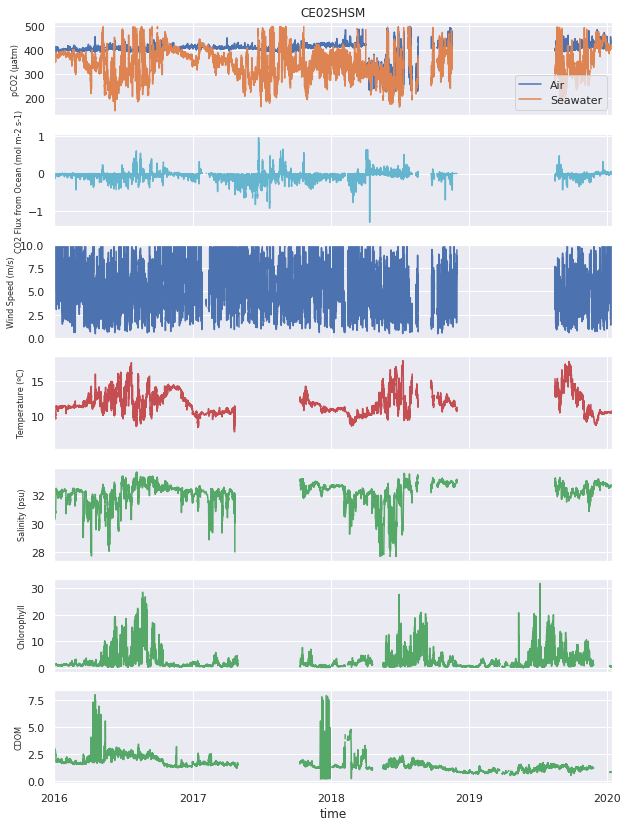

In [103]:
plot_data(ce02,'CE02SHSM')

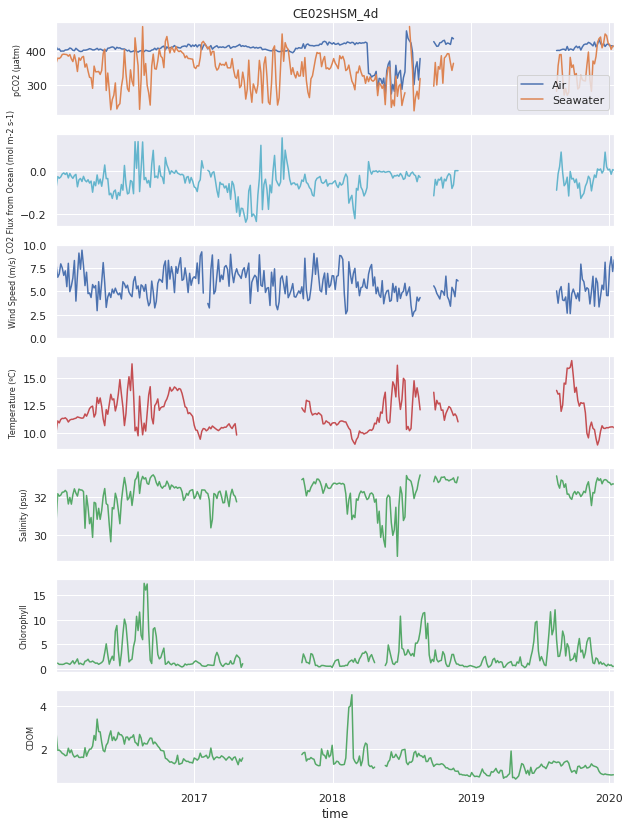

In [104]:
plot_data(ce02.resample('4D').mean().tshift(2,freq='D'),'CE02SHSM_4d')

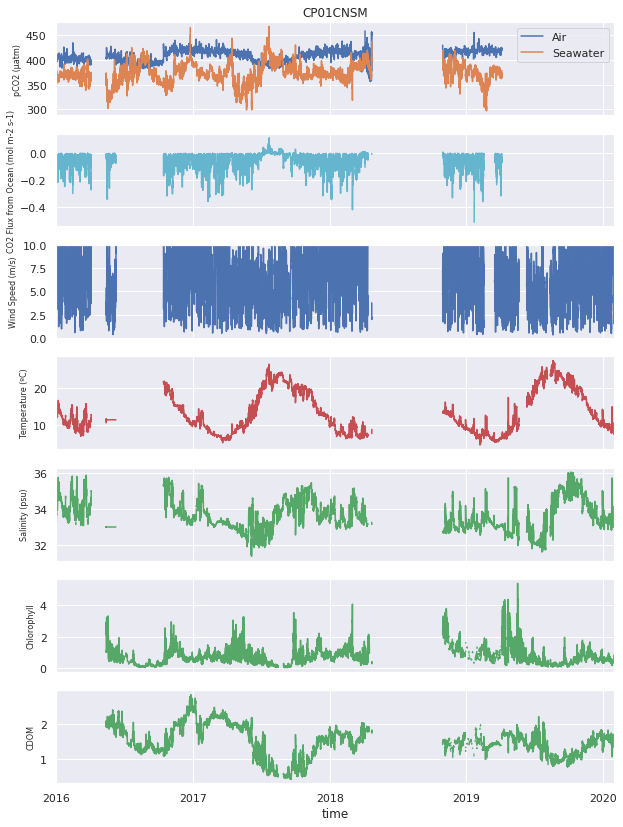

In [105]:
plot_data(cp01,'CP01CNSM')

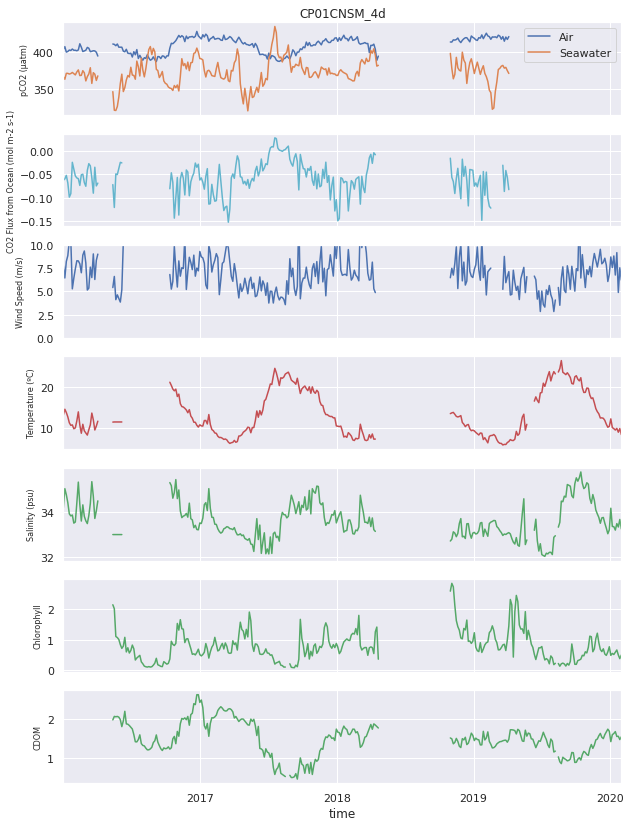

In [106]:
plot_data(cp01.resample('4D').mean().tshift(2,freq='D'),'CP01CNSM_4d')

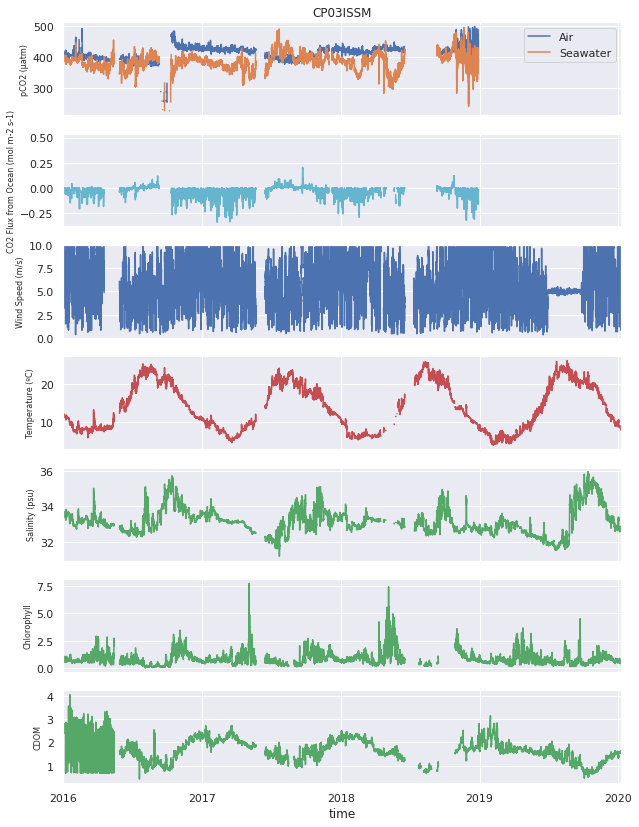

In [107]:
plot_data(cp03,'CP03ISSM')

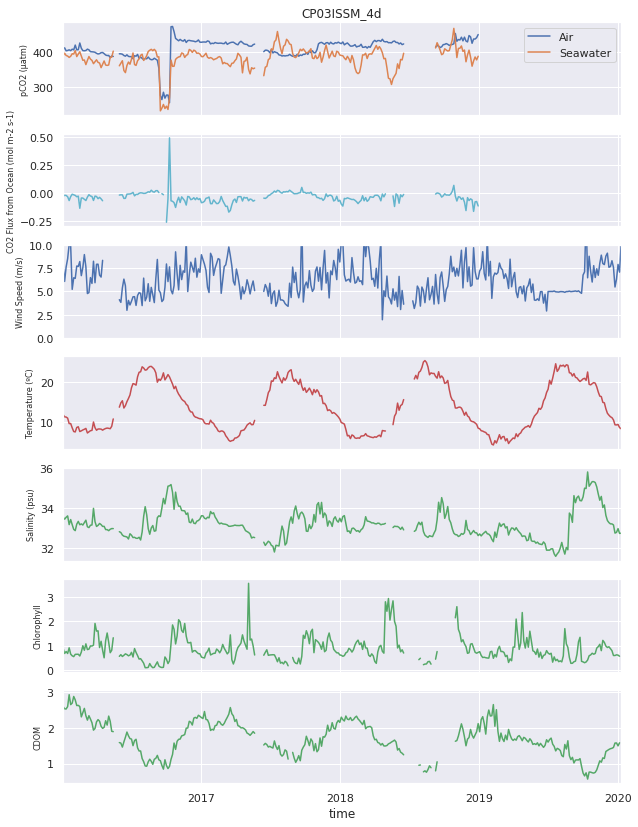

In [108]:
plot_data(cp03.resample('4D').mean().tshift(2,freq='D'),'CP03ISSM_4d')

## Step 5 - Merge the Dataset

In [0]:
a = ce02.rename(columns={'partial_pressure_co2_atm':'CE02 pCO2 Atm',
          'partial_pressure_co2_ssw':'CE02 pCO2 Sea',
          'pco2_co2flux':'CE02 CO2 Flux',
          'sea_surface_temperature':'CE02 SST',
          'met_salsurf':'CE02 Sal',
          'met_relwind_speed':'CE02 Wind',
          'fluorometric_chlorophyll_a':'CE02 Chl',
          'fluorometric_cdom':'CE02 CDOM'}).drop({'met_wind10m'},axis=1)
b = cp01.rename(columns={'partial_pressure_co2_atm':'CP01 pCO2 Atm',
          'partial_pressure_co2_ssw':'CP01 pCO2 Sea',
          'pco2_co2flux':'CP01 CO2 Flux',
          'sea_surface_temperature':'CP01 SST',
          'met_salsurf':'CP01 Sal',
          'met_relwind_speed':'CP01 Wind',
          'fluorometric_chlorophyll_a':'CP01 Chl',
          'fluorometric_cdom':'CP01 CDOM'}).drop({'met_wind10m','sea_surface_temperature_orig','met_salsurf_orig'},axis=1)
c = cp03.rename(columns={'partial_pressure_co2_atm':'CP03 pCO2 Atm',
          'partial_pressure_co2_ssw':'CP03 pCO2 Sea',
          'pco2_co2flux':'CP03 CO2 Flux',
          'sea_surface_temperature':'CP03 SST',
          'met_salsurf':'CP03 Sal',
          'met_relwind_speed':'CP03 Wind',
          'fluorometric_chlorophyll_a':'CP03 Chl',
          'fluorometric_cdom':'CP03 CDOM'}).drop({'met_wind10m','sea_surface_temperature_orig','met_salsurf_orig'},axis=1)


In [114]:
x = a.merge(b,on='time',how='outer').merge(c,on='time',how='outer')
x = x.resample('4D').mean().tshift(2,freq='D')  
x = x.dropna(how='all')
x.sample(5)

,CE02 pCO2 Atm,CE02 pCO2 Sea,CE02 CO2 Flux,CE02 SST,CE02 Sal,CE02 Wind,CE02 Chl,CE02 CDOM,CP01 pCO2 Atm,CP01 pCO2 Sea,CP01 CO2 Flux,CP01 Chl,CP01 CDOM,CP01 SST,CP01 Sal,CP01 Wind,CP03 pCO2 Atm,CP03 pCO2 Sea,CP03 CO2 Flux,CP03 Chl,CP03 CDOM,CP03 SST,CP03 Sal,CP03 Wind
time,,,,,,,,,,,,,,,,,,,,,,,,
2016-08-02,397.920204,394.486098,0.011061,10.509026,32.982974,5.287414,10.733967,2.275590,388.779845,375.581230,NaN,0.205946,1.320783,NaN,NaN,NaN,377.386026,375.116106,-0.001415,0.281961,1.052256,23.581661,33.572664,6.432204
2017-06-14,409.413362,276.876193,-0.236519,NaN,NaN,6.530763,NaN,NaN,396.702394,372.123285,-0.017672,0.512824,1.232549,13.191015,32.168216,5.055316,399.727689,332.108858,-0.043549,0.607562,1.517275,14.205620,32.273986,4.997275
2016-01-11,404.908125,377.065091,-0.035252,10.905360,32.026401,6.879581,0.944336,1.970983,399.831317,370.972963,-0.052502,NaN,NaN,13.779939,34.774420,8.227701,402.243668,388.987103,-0.019407,0.759700,2.521136,11.247392,33.529354,7.624682
2019-04-01,NaN,NaN,NaN,NaN,NaN,NaN,0.441348,0.740444,417.053196,374.668465,-0.056594,0.989903,1.402522,6.331924,33.057105,6.594565,NaN,NaN,NaN,0.938956,1.644213,5.983034,32.977519,6.459947
2018-12-22,NaN,NaN,NaN,NaN,NaN,NaN,0.460376,0.835360,413.791933,385.671417,-0.039957,0.952101,1.495494,9.748782,33.052140,7.156097,435.320615,384.799163,-0.076979,0.727221,1.796719,9.757831,32.752965,7.153352


In [0]:
# Export to CSV
x.to_csv('CO2_data.csv')

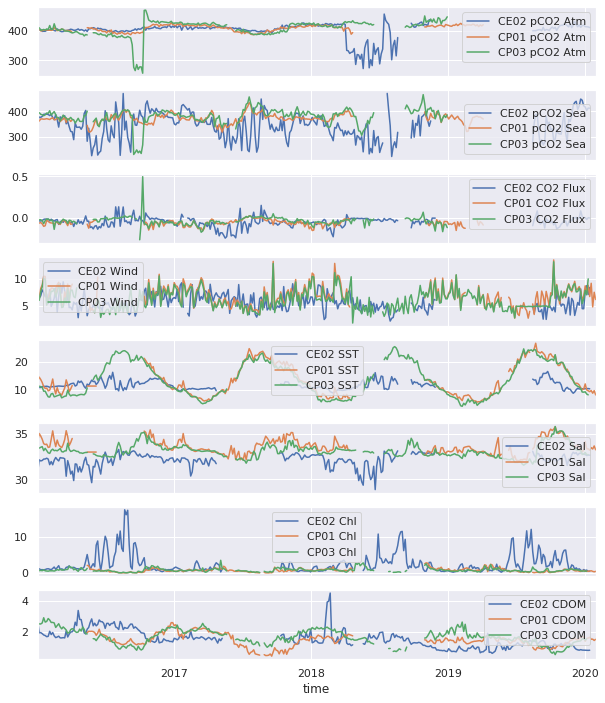

In [116]:
fig,(ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8) = plt.subplots(8,1,sharex=True,figsize=(10,12))
x[['CE02 pCO2 Atm','CP01 pCO2 Atm','CP03 pCO2 Atm']].plot(ax=ax1)
x[['CE02 pCO2 Sea','CP01 pCO2 Sea','CP03 pCO2 Sea']].plot(ax=ax2)
x[['CE02 CO2 Flux','CP01 CO2 Flux','CP03 CO2 Flux']].plot(ax=ax3)
x[['CE02 Wind','CP01 Wind','CP03 Wind']].plot(ax=ax4)
x[['CE02 SST','CP01 SST','CP03 SST']].plot(ax=ax5)
x[['CE02 Sal','CP01 Sal','CP03 Sal']].plot(ax=ax6)
x[['CE02 Chl','CP01 Chl','CP03 Chl']].plot(ax=ax7)
x[['CE02 CDOM','CP01 CDOM','CP03 CDOM']].plot(ax=ax8)
plt.savefig('CO2_final.png')